### **Investigating the Mood in the Media by Analyzing the Quotebank Data Set**

This notebook contains all data loading, cleaning and analysis corresponding to the data story [A Thing Or Two About Mood](https://sigurdkampevold.github.io/media_mood/). The notebook analyzes the mood in the media by using the Quotebank data sets from 2015 to 2020 and a data set from Wikidata. 

This notebook consists of the following sections:
- Setup
- Data cleaning
- Exploratory Data Analysis (EDA)
- Data storing
- Helper functions
- Handling of additional data sets
- Sentiment analysis by time
- Sentiment analysis by media outlets
- Sentiment analysis by subsamples
- Description and mathematical outline of methods

During the process of analyzing, we have loaded files, made changes and saved new files. All the used data sets can be found in this [drive](https://drive.google.com/drive/folders/10GVjYHqvwf_UIextesBKyL8Wd6Wr4g9Z?usp=sharing). To run the notebook, please download the data folder and put it on your desktop.

### Setup

The setup section handles the necessary installs and imports needed for the analysis

**Imports**

In [6]:
from iteration_utilities import deepflatten
import matplotlib.pyplot as plt
plt.tight_layout()
import numpy as np
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.graph_objects as go
from plotly.graph_objs import *
from plotly.graph_objects import Layout
import plotly.io as pio
pio.templates.default = "seaborn"
import seaborn as sns
sns.set_theme(context='notebook', style='white')
import scipy.stats as stats
from textblob import TextBlob
import plotly.express as px

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asbjo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [ ]:
# general path to the data folder, compatible as long as data folder is stored on the dekstop
path = os.path.expanduser("~/Desktop") + '/data_mood/'

### Data Cleaning


*In this part of the notebook, we do the necessary data cleaning for the project:*
 - Dropping rows with `NaN` or `None` values in the column `quotation`.
 - Dropping columns not related to our project to reduce the file size. We will remove the columns `quoteID` and `phase`. We know that all quotes in the Quotebank data sets from 2015 to 2020 are from "phase E". We do therefore consider these values as irrelevant.
 - Saving the cleaned data to avoid having to rerun the clean function. In the analysis part of the notebook, the cleaned data sets are used.

*In addition to the cleaning described over, we want to highlight and discuss some findings from inspecting the data on the Quotebank website:*

- Some quotes are not in English. We choose not to remove these for two reasons: 1) They will not drastically affect our analysis, as they will probably be considered neutral. This is because the Vader Lexicon we use for sentiment analysis does not include support for foreign languages. 2) We think filtering on language demands more work than reward for our project.
- Some quotes are repetitive, e.g., "Yes, yes, yes, yes, yes, yes". As our sentiment analysis will give standardized results in the range `[-1, 1]`, these quotes will not be a problem for our analysis. It could also be argued that a quote of five "yes" should be considered more positive than a quote containing one "yes".
- Some of the quotes have `None` as the most probable speaker. When analyzing subsets of the data, this is something we have to consider. However, when analyzing the entire data set, without looking at the speaker, this will not be a problem. We will, therefore, not do anything with this in the initial cleaning.

In [3]:
files_pre_cleaning = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2',
                  'quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

path_to_wikidata_file = path + 'speaker_attributes.parquet'

In [ ]:
def clean_data(chunk):
  ''' Cleaning a chunk of the data set by replacing 'None' values with NaN and dropping columns that 
  will not be used in the project.

  Parameters
  ----------
  chunk: dataframe
    An uncleaned chunk of the data set.

  Returns
  -------
  chunk: dataframe
    A cleaned version of the chunk.
  '''

  # Replacing quotes of None with NaN values
  chunk['quotation'] = chunk['quotation'].replace('None', np.nan)

  # Dropping NaN values
  chunk = chunk.dropna(axis=0, subset=['quotation'])

  # Dropping column 'quoteID' and 'phase' to reduce filesize
  chunk = chunk.drop(axis=1, columns = 'quoteID')
  chunk = chunk.drop(axis=1, columns = 'phase')
  
  return chunk


# Reading and cleaning the data set in chunks and stores the cleaned data in compressed csv files
for x in range(len(files_pre_cleaning)):
  df_reader = pd.read_json(path + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=500000)
  for chunk in df_reader:
      cleaned_chunk = clean_data(chunk)
      
      filename = files_cleaned[x]
      cleaned_chunk.to_csv(path_or_buf=path + filename, compression='bz2', mode='a')

  print(f'Cleaned {files_pre_cleaning[x]}')


### Helper Functions


This section contains helper functions from milestone 2 that are utilized in the final project.

__Functions for dealing with date and time__

In [5]:
def weekday_number(date):
  ''' Returning the weekday number of a date, e.g., 0 for Mondays.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday number.

  Returns
  -------
  weekday_number: int
    The weekday number of the date.
  '''

  weekday_number = date.weekday()
  return weekday_number


def weekday(date):
  ''' Returning the name of the weekday for a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  weekday: str
    The weekday of the date.
  '''
  
  day_number = date.weekday()
  week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  weekday = week_days[day_number]
  return weekday


def week(date):
  ''' Returning the week number of a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  week_number: int
    The week number of the date.
  '''

  week_number = date.week()
  return week_number


def month(date):
  ''' Returning the month name of date.

  Parameters
  ----------
  date: datetime
    A date for which to find the month name.

  Returns
  -------
  name_month: str
    The name of the month.
  '''

  name_month = date.month_name()
  return name_month


def add_time(chunk):
  ''' Adding columns for weekday, weekday number and month name to a chunk.

  Parameters
  ----------
  chunk: dataframe
    The chunk for which to add date information.

  Returns
  -------
  chunk: dataframe
    The chunk with date information.
  '''

  chunk['weekday'] = chunk['date'].apply(lambda x: weekday(x))
  chunk['weekday_number'] = chunk['date'].apply(lambda x: weekday_number(x))  
  chunk['Month'] =  chunk['date'].apply(lambda x: month(x))
  chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
  return chunk

__Helper functions for dealing with dictionaries__

In [ ]:
def add_dict(key, dictionary):
  ''' Incrementing the value of a key in a dictionary.
  
  Parameters
  ----------
  key: object
    The key for which to increment the value.
  
  dictionary: dict
    A dictionary in which we are incrementing the value of the key, or adding the key if not already present.

  Returns
  -------
  dictionary: dict
    The given dictionary after incrementing the value.
  '''
  
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1
  return dictionary


def to_dict(dictionary, chunk_column):
  ''' Making a column of a dataframe into a dictionary, e.g., making a dictionary where weekdays are keys,
  and the values are the number of occurences of the key in the key.
  
  Parameters
  ----------
  dictionary: dict
    An initalized dictionary, either containing some preset keys or empty.
  
  chunk_column: series
    A series containing a column of a dataframe.

  Returns
  -------
  dictionary: dict
    A dictionary containing the desired values and keys as descripted.
  '''

  chunk_column.apply(lambda x: add_dict(x, dictionary))
  return dictionary

__Functions for extracting media information__

In [7]:
def find_media(url, medias_list):
  ''' Returning the media outlet where the quote is found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  url: array
    An entry in the column 'urls' of the Quotebank data set, where the first value is the first source where the quote was found.
  
  medias_list: array
    An array containing some chosen media outlets, e.g., 'nytimes'.
  
  Returns
  -------
  media: str
    The first entry in url if its present in medias_list.
  '''

  for string in medias_list:
    url_string = str(url[0])
    if string in url_string:
      media = string
      return media


def get_media(chunk, medias_list):
  ''' Adding column with the media outlet where the quote is first found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  chunk: dataframe  
    A chunk of the Quotebank data set.

  medias_list: array
    An array containing some chosen media outlets represented as strings, e.g., 'nytimes'.

  Returns
  -------
  chunk: dataframe
    The given chunk of the data set, now containing a column 'media_outlet' 
    keeping the media where the quote was first found.
  '''

  chunk['media_outlet'] = chunk['urls'].apply(lambda x: find_media(x, medias_list))
  return chunk

__Functions for descriptive statistics__

In [ ]:
def occurences_stats(chunk):
  ''' Returning the median and 75-th percentile of 'numOccurences' for the given chunk.
  
  Parameters
  ----------
  chunk: dataframe
    The dataframe keeping a chunk of the data set.
  
  Returns
  -------
  chunk_stats: array
    An array containing the median and the 75-th percentile.
  '''
  
  median = chunk.numOccurrences.describe()['50%']
  third_quartile = chunk.numOccurrences.describe()['75%']
  chunk_stats = [median, third_quartile]
  return chunk_stats


def stats_entire_dataset(occurence_stats_list):
  ''' Aggregating and printing statistics on numOccurences for the entire data set based upon the values in occurence_stats_list.
  
  Parameters
  ----------
  occurence_stats_list: array
    A 2D-array containing inner arrays with median and 75th percentile for each chunk of the data set.   
  '''

  avg_median = 0
  avg_75th = 0
  for element in occurence_stats_list:
    avg_median += element[0]
    avg_75th += element[1]
  avg_median = avg_median/len(occurence_stats_list)
  avg_75th = avg_75th/len(occurence_stats_list)

  print(f'Average of median for each chunk for numOccurences: {round(avg_median, 2)}')
  print(f'Average 75th quantile for each chunk for  numOccurences: {round(avg_75th, 2)}')


def add_length(chunk):
  ''' Helper function adding the length of each quote to a new column.
  
  Parameters
  ----------
  chunk: dataframe
    A chunk of the data set.
    
  Returns
  -------
  chunk: dataframe
    The given chunk containing a 'len_quote' column.
  '''

  chunk['len_quote'] = chunk['quotation'].apply(lambda x: len(str(x)))
  return chunk

### Exploratory Data Analysis

The Exploratory Data Analysis section inspects the data to understand the underlying distributions of the data, identify anomalies and get a grasp of the overall patterns of the data.

__The distribution of the length of quotes and number of occurences for one chunk of size 200 000 from the 2020 data set__

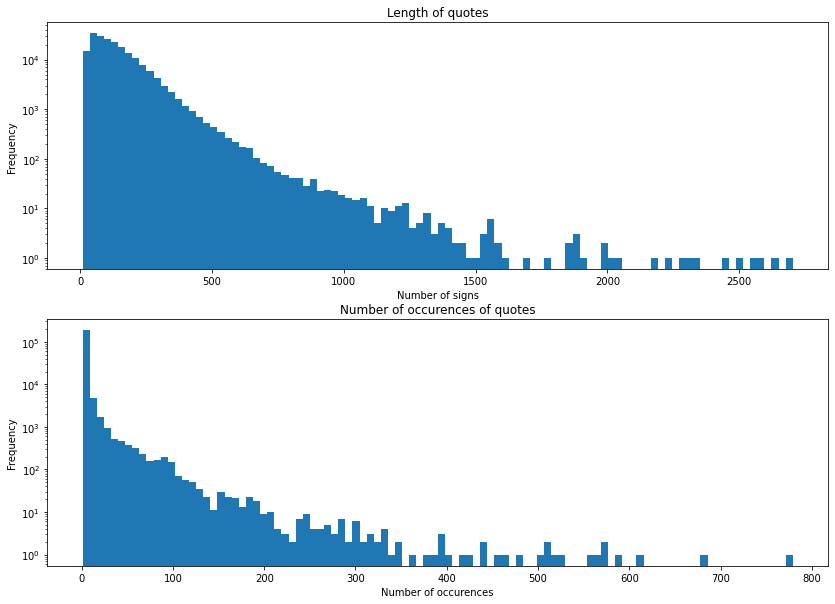

In [ ]:
# Loading one chunk of size 200 000 from the 2020 data set.
df_reader = pd.read_json(path + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=200000)
for chunk in df_reader:
  break

# Adding a 'len_quote' column to the chunk
chunk = add_length(chunk)

# Plotting the distribution of 'len_quote' and 'numOccurences' for visual inspection
fix, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].hist(chunk.len_quote, bins=100)
ax[0].set_title("Length of quotes")
ax[0].set_xlabel("Number of signs")
ax[0].set_ylabel("Frequency")
ax[0].set_yscale('log')

ax[1].hist(chunk.numOccurrences, bins=100)
ax[1].set_title("Number of occurences of quotes")
ax[1].set_xlabel("Number of occurences")
ax[1].set_ylabel("Frequency")
ax[1].set_yscale('log')

plt.show()

- The plots show that the length of quotes and the number of occurrences follow a heavy-tailed distribution. We keep this in mind when reporting descriptive statistics.
- We observe outliers in the form of long quotes. We do not remove these as we do not think they will affect our sentiment analysis. In addition, we have no reason to claim they are wrong, even though it could be reasoned that 2000+ sign quotes may result from misclassification from the Quotebank algorithm. 
- For the number of occurrences, we see that most quotes are quoted a few times, but some are repeated many times. This is important for our sentiment analysis since the quotation sentiment should be scaled by the number of occurrences to reflect the total sentiment in the media correctly.

In [ ]:
# Showing the head of a chunk of the 2020 dataset for visual inspection
chunk.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,len_quote
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E,276
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,91
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E,264
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E,33
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E,102


The data seems to have loaded as expected, and we do not notice any errors immediately.

__Calculating descriptive statistics and gathering data on the whole data set__


In [ ]:
# Initializing an array that will store the mean and variance of 'numOccurences' as well as the size of a chunk
occurence_stats_list = []

# Initializing dictionaries for dates, weekdays and months that will store values for all the chunks
date_dictionary = {}

# Dictionaries for weekdays and months are initialized with keys to keep them in the correct order for later plotting
weekday_dictionary = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0,
                      'Friday': 0, 'Saturday': 0, 'Sunday': 0}

month_dictionary = {'January': 0, 'February': 0,'March': 0,
                    'April': 0, 'May': 0, 'June': 0, 
                    'July': 0, 'August': 0, 'September': 0,
                    'October': 0, 'November': 0, 'December': 0}

# Iterating through all the cleaned data sets in chunks
for x in range(len(files_pre_cleaning)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(path + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=50000)
  for chunk in df_reader:
    chunk = add_time(chunk)
    
    # Inserting values in the dictionaries
    date_dictionary = to_dict(date_dictionary, chunk['date_short'])
    weekday_dictionary = to_dict(weekday_dictionary, chunk['weekday'])
    month_dictionary = to_dict(month_dictionary, chunk['Month'])

    # Generating descriptive stats for the chunk and adding them to occurence_stats_list
    occurence_stats_list.append(occurences_stats(chunk))

# Creating empty array to store dictionary values
arr = []
for element in date_dictionary.values():
    arr.append(element)
arr = np.array(arr)

# Calculating mean, std, and median for date_dictionary
mean = np.mean(arr)
std = np.std(arr)
median = np.median(arr)

__Descriptive statistics for the number of quotes and the number of occurrences for quotes__

In [ ]:
print(f'Mean of quotes per day: {round(mean, 2)}\nStandard deviation of quotes per day: {round(std, 2)}\nMedian of quotes per day: {round(median, 2)}\n')

# Printing the average of median and 75th quantile per chunk for numOccurences for the entire data set
stats_entire_dataset(occurence_stats_list)

Mean of quotes per day: 59764.35
Standard deviation of quotes per day: 31690.1
Median of quotes per day: 64147.5

Average of median for each chunk for numOccurences: 1.0
Average 75th quantile for each chunk for  numOccurences: 2.0


- On average, there are around 60 000 quotations per day. The standard deviation is very high, probably because of the gaps in 2015-2017 that can be seen in the plot below.
- For the number of occurrences, we report the average of the median and the average of the 75th quantile for the chunks. This is because it follows a heavy-tailed distribution, and it is necessary to report robust statistics.
- We see that the average median per chunk for numOccurences is one and the 75th quantile is two. This shows that most quotes are quoted few times.

__Number of quotes per day for the entire data set on a log-scaled Y-axis__

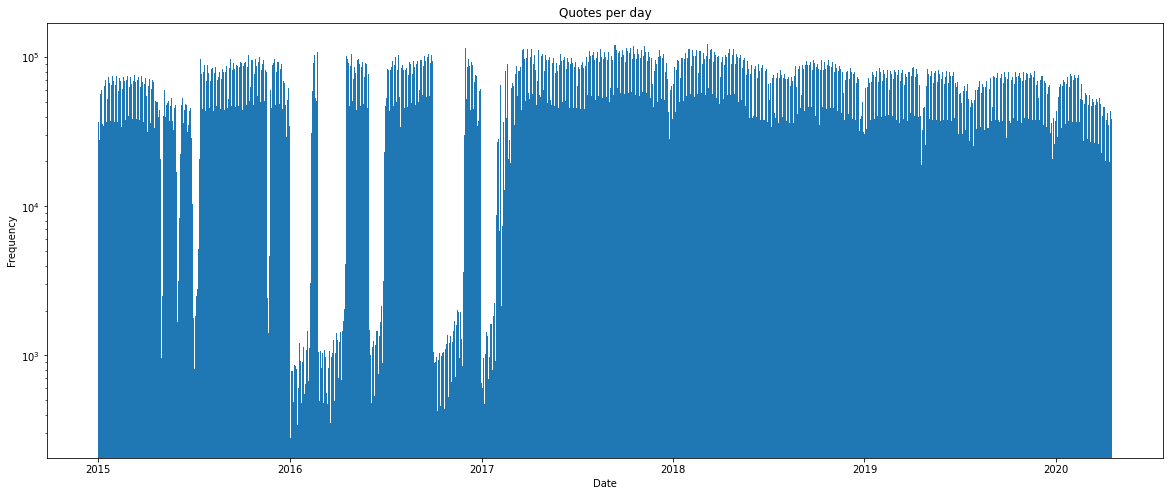

In [ ]:
fig, ax=plt.subplots(1,1, figsize = (20,8))
ax.bar(date_dictionary.keys(), date_dictionary.values(), width=1.0)
ax.set_title("Quotes per day")
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.set_yscale('log')
plt.show()

__Number of quotes per day for the entire data set__

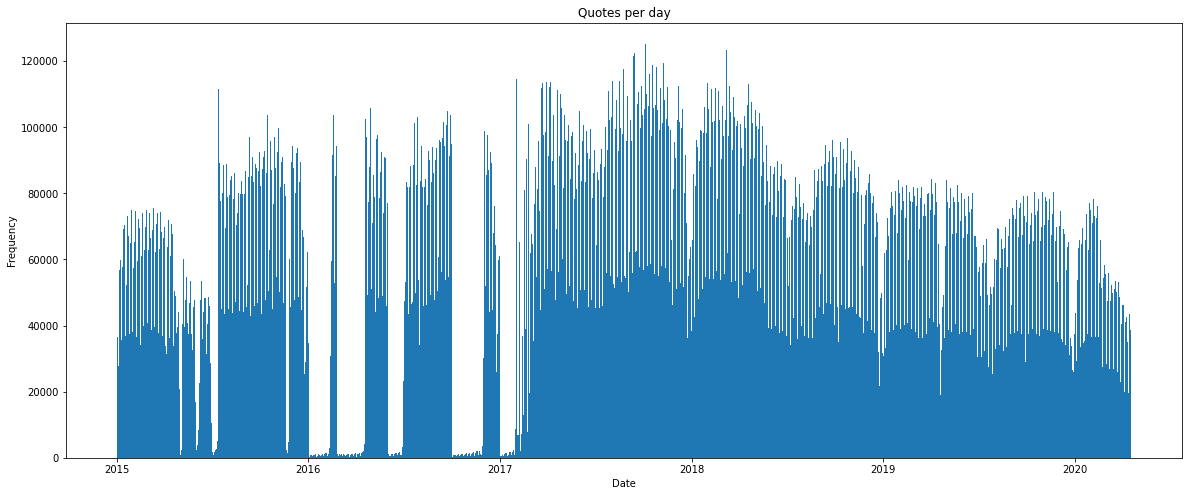

In [ ]:
fig, ax=plt.subplots(1,1, figsize = (20,8))
ax.bar(date_dictionary.keys(), date_dictionary.values(), width=1.0)
ax.set_title("Quotes per day")
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
plt.show()

- We notice that there are some large gaps between 2015 and 2017 where very few quotes was registered which should be kept in mind for future analyses

__Quotes per weekday__

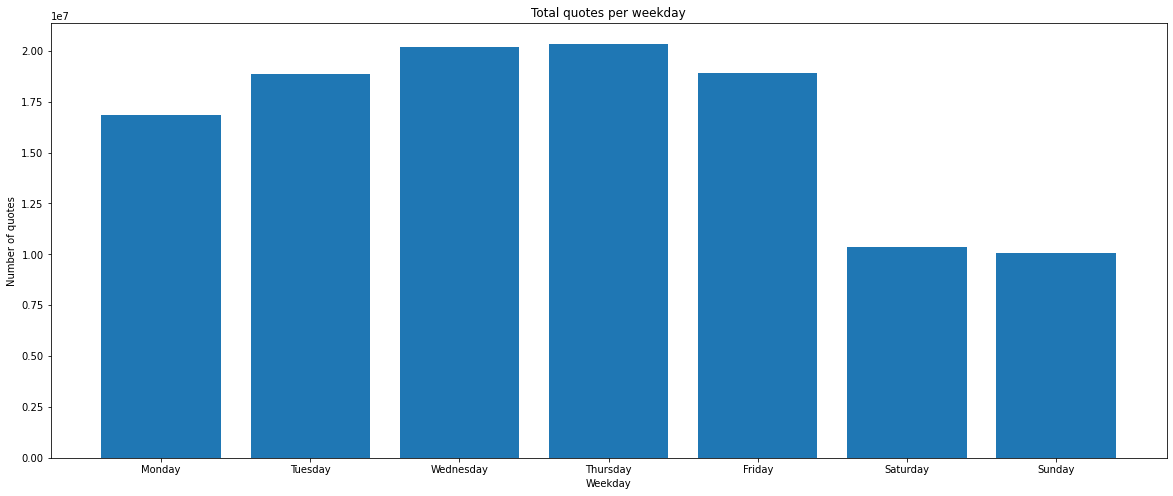

In [ ]:
fig, ax = plt.subplots(1, figsize = (20,8))
ax.bar(weekday_dictionary.keys(), weekday_dictionary.values())
ax.set_title("Total quotes per weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Number of quotes")
plt.show()

- The plot shows, as expected, that there are fewer quotes in the weekends

__Quotes per month__

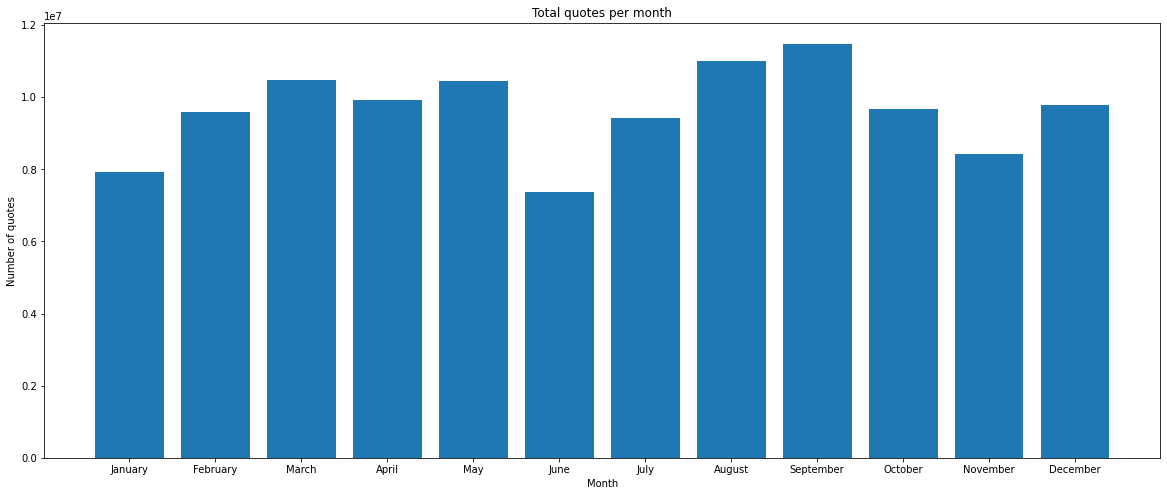

In [ ]:
fig, ax = plt.subplots(1, figsize = (20,8))
ax.bar(month_dictionary.keys(), month_dictionary.values())
ax.set_title("Total quotes per month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of quotes")
plt.show()

- We see that the number of quotes varies across months. There are several natural reasons for this:
 - In 2020, only quotes from January to April are included
 - Between 2015 and 2017, there are, as aforementioned, gaps in quotes for some months. From this and the plots above, it seems like January, June, and November have been most severely impacted. 

### Additional Data Set


As mentioned in the ReadMe, we use the Wikidata data set to enrich our analyses. It is mainly used for determining whether a speaker is a man or woman and whether the speaker is a politician or not. In this section, we have included the necessary code to extract this information from the data set. 

In [4]:
# Reading the Wikidata files
read_wikidata_parquet = pd.read_parquet(path_to_wikidata_file)
read_wikidata_parquet.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


The wikidata data set loaded as expected

__Functions for extracting quotes by politicians and gender__

In [ ]:
def find_alias_in_wiki(alias):
  ''' Returning a dataframe, consisting of one row, with Wikidata information about the given alias .
  
  Parameters
  ----------
  alias: str
    A given alias to look up in the Wikidata files
    
  Returns
  -------
  match: dataframe
    A dataframe containing information about the given alias.
  '''
  
  index = []
  for i, aliases in enumerate(read_wikidata_parquet['aliases']):
    if aliases is None:
      continue
    if alias in aliases:
        index.append(i)
  
  match = read_wikidata_parquet.loc[index]
  return match

# Testing the above function by looking up President Washington
print(find_alias_in_wiki("President Washington"))

                                             aliases  ...   religion
0  [Washington, President Washington, G. Washingt...  ...  [Q682443]

[1 rows x 15 columns]


In [ ]:
def dataset_filtered_on_aliases(aliases, dataset):
  '''Returning a filtered dataframe containing rows where 'speaker' is present in aliases array.
  
  Parameters
  ----------
  aliases: array
    An array containing desired aliases to filter on.
    
  dataset: dataframe
    The dataframe to filter.
    
  Returns
  -------
  dataset_alias_filtered: dataframe
    The given data set filtered as described.
  '''
  
  dataset_alias_filtered = dataset[dataset['speaker'].isin(aliases)]
  
  # Replacing speakers of None with NaN values
  dataset_alias_filtered['speaker'] = dataset_alias_filtered['speaker'].replace('None', np.nan)
  
  # Dropping NaN values
  dataset_alias_filtered = dataset_alias_filtered.dropna(axis=0, subset=['speaker'])
  return dataset_alias_filtered


def dataset_filtered_on_politicians(wikidata, dataset):
  ''' Returning a filtered dataframe only containing quotes by politicians. 
  Note that a person can be listed with many professions and therefore distringuishing
  someone who is a former politican can be difficult.

  Parameters
  ----------
  wikidata: dataframe
    A dataframe containing the Wikidata data set.

  dataset: dataframe
    A dataframe to filter on politicians.

  Returns
  -------
  dataset_filtered_on_politicans: dataframe
    A dataframe filtered as described.
  '''

  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))

  # Returns original data set filtered on the speakers corresponding to politicians
  dataset_filtered_on_politicans = dataset_filtered_on_aliases(all_wiki_aliases_politician_filtered, dataset)
  return dataset_filtered_on_politicans


def conv_to_string(x):
  ''' Converting the first element of a list x to a string. 
  If the input not is a list, it returns 'N/A.

  Parameters
  ----------
  x: array
    An array where we want to convert the first element into a string.

  Returns
  -------
  first_elem: str
    The first element of the array converted into a string or 'N/A' if the input is not a list.
  '''

  try:
    first_elem = str(x[0])
    return first_elem
  except:
    return 'N/A'

def isPolitician(array):
  ''' Checking whether the QID for the politician occupation is in array.
  
  Parameters
  ----------
  array: array 
    An array to check whether the QID is in.
    
  Returns
  -------
  bool
    A boolean telling whether the QID correspond to a polication or not.'''

  try:
    # Uses harcoded QID for politician == Q82955
    if 'Q82955' in array:
      return True
    else:
      return False
  except:
    return False

def dataset_filtered_on_gender_with_alias(gender, wikidata, dataset):
  ''' Filtering data set on gender given the information in Wikidata
      Only includes a row if the speaker is not 'None'.
  Parameters
  ----------
  gender: str
    A string either 'male' or 'female'.
  
  wikidata: dataframe
    A dataframe containing the Wikidata data set.

  dataset: dataframe
    The dataset to filter on gender.

  Returns
  -------
  dataframe
    The given data set filtered on gender.
  '''
  
  if gender == 'male' or gender == 'female':
    gender_qid = 'Q6581097' if gender == 'male' else 'Q6581072'
    # Converting the gender column to string to be able to check if it equals gender_qid
    wikidata['gender'] = wikidata['gender'].apply(lambda x: conv_to_string(x))
    wikidata_gender_filtered = wikidata.loc[wikidata['gender'] == gender_qid]

  else:
    print("Invalid gender, the function does only consider binary genders.")
    exit()
  
  # After filtering on gender, make turn all aliases into 1D list
  all_wiki_aliases_gender_filtered = wikidata_gender_filtered['aliases'].tolist()
  all_wiki_aliases_gender_filtered = list(deepflatten(all_wiki_aliases_gender_filtered, depth=1))
  
  # Returning original data set filtered on the speakers corresponding to a gender
  return dataset_filtered_on_aliases(all_wiki_aliases_gender_filtered, dataset)

__Testing the gender and politicians filtering functions__

In [ ]:
# Testing whether the above-mentioned functions work by creating two dataframes. 
# 'males' includes only male speakers while 'politicians' includes only speakers that are politicans.
df_reader = pd.read_json(path + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=100000)
for chunk in df_reader:
  males = dataset_filtered_on_gender_with_alias('male', read_wikidata_parquet, chunk)
  politicians = dataset_filtered_on_politicians(read_wikidata_parquet, chunk)
  break

In [ ]:
males.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
25,2020-02-18-000907,A city is not an accident but the result of co...,Leon Krier,[Q970000],2020-02-18 09:39:38,1,"[[Leon Krier, 0.8559], [None, 0.1441]]",[http://allafrica.com/stories/202002180401.html],E
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
34,2020-02-29-000491,a lack of resources and government funding,Paul Harvey,"[Q16195572, Q16204369, Q39074951, Q47350253, Q...",2020-02-29 00:13:45,1,"[[Paul Harvey, 0.9212], [None, 0.0788]]",[http://basingstokegazette.co.uk/news/18270936...,E
62,2020-02-17-001857,"Absolutely they could (cause some upsets),",Tim Cridland,[Q8065902],2020-02-17 00:40:00,1,"[[Tim Cridland, 0.9051], [None, 0.0949]]",[http://www.dailymercury.com.au/news/rival-ski...,E
68,2020-04-03-002052,After talking with Chris about his background ...,Brad Smith,"[Q15477554, Q16218831, Q23664265, Q24084114, Q...",2020-04-03 15:16:31,1,"[[Brad Smith, 0.7482], [None, 0.2469], [Chris ...",[http://www.hmenews.com/article/brief-package-...,E


The male filtering seems to have worked as expected

In [ ]:
politicians.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],2020-01-26 13:21:36,11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...,E
72,2020-02-07-003833,All future inquiries should be directed to the...,Seamus Ryan,[Q7440788],2020-02-07 22:11:55,1,"[[Seamus Ryan, 0.6351], [None, 0.3649]]",[https://www.koaa.com/news/news5-investigates/...,E
88,2020-01-23-004492,"Although not a lubricant issue, tire wear is e...",John Burke,"[Q15451851, Q16188889, Q16297972, Q1699458, Q2...",2020-01-23 16:23:57,1,"[[John Burke, 0.7478], [None, 0.2522]]",[http://www.theenergycollective.com/node/40103...,E
105,2020-01-09-005110,And his own drama is that he's stuck in this c...,John Moore,"[Q10500229, Q1537696, Q16089768, Q16106364, Q1...",2020-01-09 06:00:48,1,"[[John Moore, 0.7892], [None, 0.2108]]",[https://www.seattletimes.com/entertainment/mo...,E
109,2020-01-23-005418,And I think we've come to a time where we are ...,Sheila Oliver,[Q7493177],2020-01-23 21:15:14,1,"[[Sheila Oliver, 0.9228], [None, 0.0772]]",[https://wobm.com/how-toxic-is-nj-political-cl...,E


Some quick Google searches indicates that the filtering has worked for politicians as well

### Data Storing

This section runs the code that implements the necessary calculations for the analyses and stores the results in new files. There are three of these storing operations, one for each part of the analysis, i.e. mood across time, mood across media outlets, and mood across subsamples. Three seperate storing operations may seem redundant, but we chose to do it this way to ease the division of work. This way, each person needed only to do the calculations for his own part and we avoided having to work with larger data sets than needed.

#### Mood Across Time

Calculating and storing the data needed for the analysis on mood across time

In [1]:
# Defining data paths
files = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2',
                  'quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2']

Storing time data, semtiment scores and media outlet for all quotations in the data set

In [ ]:
# Initializing the sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Defining relevant media outlets
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'si', 'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

# Iterating through all the cleaned data sets in chunks and saving compound, polarity and subjectivity score, and media outlet
for x in range(len(files)): 
  print('Working on %d. dataset'%(x + 1))
  df_reader = pd.read_json(path + files[x], lines=True, compression='bz2', chunksize=50000)
  a = 0
  for chunk in df_reader:
    # Adding date, month, and weekday to the dataframe
    chunk = add_time(chunk)
    
    # Calculating compound score with NLTK Vader
    chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

    # Computing polarity and subjectivity score with Text Blob
    chunk['polarity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    chunk['subjectivity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[1])

    # Adding the media outlet to the dataframe if the media outlet is included in media_outlets
    chunk = get_media(chunk, media_outlets)
    
    # Only keeping relevant columns
    chunk = chunk[['date_short','compound','polarity','subjectivity','media_outlet','weekday', 'Month']]

    # Writing the chunk to a csv file
    chunk.to_csv(path_or_buf=path+'fil%d.csv.bz2'%x, compression='bz2', mode = 'a')

In [ ]:
# Reading all the newly created quote files into one large dataframe
files = [path+'fil%d.csv.bz2'%i for i in range(6)]
df = pd.concat(map(pd.read_csv, [files[i] for i in range(6)]))

Formatting the new dataframe

In [ ]:
# Converting relevant columns to numeric
df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['polarity'] = pd.to_numeric(df.polarity, errors='coerce')
df['subjectivity'] = pd.to_numeric(df.subjectivity, errors='coerce')

# Dropping excessive column
df = df.drop('Unnamed: 0', axis=1)

# Sorting dataframe by date for enabling visualizing time series
df = df.sort_values(by=['date_short'])

# Dropping rows with Nan values except for nan values in media_outlet
df_new = df.dropna(subset=['date_short','compound', 'polarity', 'subjectivity','weekday','Month'])

Checking whether the formatting have worked as expected by studying the tail of the old and new dataframe

In [ ]:
# original dataframe
df.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
17100341,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
17150342,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
17200343,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
16150322,date_short,NaN,NaN,NaN,media_outlet,weekday,Month
25100501,date_short,NaN,NaN,NaN,media_outlet,weekday,Month


In [ ]:
# formatted dataframe
df_new.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2549961,2020-04-17,0.7506,0.250000,0.35,NaN,Friday,April
5020444,2020-04-17,0.0000,0.000000,0.00,NaN,Friday,April
2902381,2020-04-17,-0.5191,0.179167,0.45,NaN,Friday,April
1597999,2020-04-17,-0.2023,-0.187500,0.50,NaN,Friday,April
3854446,2020-04-17,0.0258,0.000000,0.00,NaN,Friday,April


We see that that NaN values are succesfully dropped.

In [ ]:
# Checking the number of rows that were dropped due to NaN values
print("Number of rows dropped: %d"%(df.size - df_new.size))

Number of rows dropped: 16177


In [ ]:
# Writing the formatted dataframe into a new single csv file for ease of use
df_new.to_csv(path_or_buf=path+'complete.csv.bz2', compression='bz2', mode = 'a')

#### Mood Across Media Outlets - Data Storing

Calculating and storing the data needed for the analysis on mood across media outlets

In [1]:
# Cleaning of files from milestone 2
files = ['quotes-2015.json-001.bz2','quotes-2016.json-002.bz2','quotes-2017.json.bz2',
                  'quotes-2018-004.json.bz2','quotes-2019-005.json.bz2','quotes-2020.json.bz2']

# Path to files after adding media and remove unnecessary columns
files_with_sentiment = ['clean-quotes-2015_with_sentiment.csv.bz2','clean-quotes-2016_with_sentiment.csv.bz2','clean-quotes-2017_with_sentiment.csv.bz2',
                  'clean-quotes-2018_with_sentiment.csv.bz2','clean-quotes-2019_with_sentiment.csv.bz2','clean-quotes-2020_with_sentiment.csv.bz2']

# The media outlets that will be studied in the analysis
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

In [ ]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Iterating through the cleaned files
for x in range(len(files)):
# Reading the data in chunks
  df_reader = pd.read_json(path + files[x], lines=True, compression='bz2', chunksize=500000)
  for chunk in df_reader:

    # Dropping unnecesary columns
    chunk = chunk.drop(axis=1, columns = 'quoteID')
    chunk = chunk.drop(axis=1, columns = 'phase')
    chunk = chunk.drop(axis=1, columns = 'speaker')
    chunk = chunk.drop(axis=1, columns = 'qids')
    chunk = chunk.drop(axis=1, columns = 'numOccurrences')
    chunk = chunk.drop(axis=1, columns = 'probas')
    
    # Adding media outlet if substring found in url
    chunk = get_media(chunk, media_outlets)
    
    # Dropping NaN values in media_outlet
    chunk = chunk.dropna(axis=0, subset=['media_outlet'])
    chunk = chunk.drop(axis=1, columns = 'urls')

    # Calculating compound sentiment scores for the chunk and appending the values in a column
    chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    chunk['positive'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
    chunk['negative'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
    chunk['blob_polar'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.polarity)
    chunk['blob_subj'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    chunk = chunk.drop(axis=1, columns = 'quotation')

    # Adding date_short
    chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
    chunk = chunk.drop(axis=1, columns = 'date')
    
    # Writing chunk to csv
    chunk.to_csv(path_or_buf= path + files_with_sentiment[x], compression='bz2', mode = 'a')
    print('chunk OK')

#### Mood Across Subsamples - Data Storing

Calculating and storing the data needed for the analysis on mood across subsamples

In [4]:
# Defining files and filepaths

files_pre_cleaning = ['quotes-2015.csv.bz2','quotes-2016.csv.bz2','quotes-2017.csv.bz2',
                  'quotes-2018.csv.bz2','quotes-2019.csv.bz2','quotes-2020.csv.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

files = files_pre_cleaning

path_to_wikidata_file = path + 'wikidata.csv'

In [6]:
# Reading processed Wikidata file, not necessary if parquet version loaded
read_wikidata_parquet = pd.read_csv(path_to_wikidata_file)

Helper functions for extracting aliases

In [ ]:
def get_politician_aliases(wikidata):
  ''' Returns a filtered dataframe containing all aliases by politicians. 
  Note that a person can be listed with many professions and therefore distringuishing
  someone who is a former politican can be difficult.

  Parameters
  ----------
  wikidata: dataframe
    A dataframe containing the Wikidata data set.

  Returns
  -------
  dataset_filtered_on_politicans: list
    A 1D list with the filtered alias strings.
  '''

  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))
  return all_wiki_aliases_politician_filtered


def get_all_aliases_of_gender(gender, wikidata):
  ''' Returns a 1D list containing all aliases we can identify by one of the genders. 

  Parameters
  ----------
  gender: string
    A string specifying the requested gender.
    Function only handles male and female.
    
  wikidata: list
    A list containing the Wikidata data set.

  Returns
  -------
  1D list of all aliases belonging to a gender in wikidata
  '''

  if gender == 'male' or gender == 'female':
    gender_qid = 'Q6581097' if gender == 'male' else 'Q6581072'
    # Converting the gender column to string to be able to check if it equals gender_qid
    wikidata_copy = wikidata.copy()
    wikidata_copy['gender'] = wikidata_copy['gender'].apply(lambda x: conv_to_string(x))
    wikidata_gender_filtered = wikidata_copy.loc[wikidata_copy['gender'] == gender_qid]

  else:
    print("Invalid gender, the function does only consider binary genders.")
    exit()
  
  # After filtering on gender, turn all aliases into 1D list
  all_wiki_aliases_gender_filtered = wikidata_gender_filtered['aliases'].tolist()
  all_wiki_aliases_gender_filtered = list(deepflatten(all_wiki_aliases_gender_filtered, depth=1))
  return all_wiki_aliases_gender_filtered

In [ ]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Retrieve all identifiable aliases of the relevant demographics: males, females and politicians
male_aliases = get_all_aliases_of_gender('male', read_wikidata_parquet)
female_aliases = get_all_aliases_of_gender('female', read_wikidata_parquet)
politician_aliases = get_politician_aliases(read_wikidata_parquet)

In [ ]:
# Iterating through the cleaned data sets in chunks and saving compound, polarity, and subjectivity score for males, females and politicians
for x in range(len(files)): 
  print('Working on %d. dataset'%(x + 1))
  df_reader = pd.read_json(path + files[x], lines=True, compression='bz2', chunksize=400000)
  a=0
  for chunk in df_reader:
    print("New chunk")
    
    # Adding date, month, and weekday to the df
    chunk = add_time(chunk)

    # Creating three dataframes from the chunk filtered on subsamples aliases
    females = dataset_filtered_on_aliases(female_aliases, chunk)
    males = dataset_filtered_on_aliases(male_aliases, chunk)
    politicians = dataset_filtered_on_aliases(politician_aliases, chunk)
        
    # Calculating compound score with NLTK Vader
    females['compound'] = females['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    males['compound'] = males['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    politicians['compound'] = politicians['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

    # Computing polarity and subjectivity score with Text Blob
    females['polarity'] = females['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    males['polarity'] = males['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    politicians['polarity'] = politicians['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
    females['subjectivity'] = females['quotation'].apply(lambda x: TextBlob(x).sentiment[1])
    males['subjectivity'] = males['quotation'].apply(lambda x: TextBlob(x).sentiment[1])
    politicians['subjectivity'] = politicians['quotation'].apply(lambda x: TextBlob(x).sentiment[1])

    # Only keeping relevant columns
    females = females[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    males = males[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    politicians = politicians[['speaker', 'date_short', 'compound', 'polarity', 'subjectivity', 'weekday', 'Month']]
    
    # Writing the chunks to three csv files
    # One for males, one for females, and one for politicians
    males.to_csv(path_or_buf=path + 'males_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
    females.to_csv(path_or_buf=path + 'fesmales_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
    politicians.to_csv(path_or_buf=path + 'politicians_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')

### Analysis

This section performs the analysis that the data story is based upon. We create plots to visualize differences and perform statistical tests to determine the statistical signficance of our findings. To ensure the integrity of our findings we defined a signficance level of $1\%$ for all analyses before studying them. This way, we avoid the temptation of doing *p-value hacking*. 

To perform the analysie, we often refer to the compound sentiment score from the *NLTK* library. Shortly, the compound score references the total sentiment of a quote standardized to be a value between $-1$ and $1$. We do also use the *TextBlob* library, which gives us polarity and subjectivity score. The polarity scores aim to quantify the level of postivity and negativity of a statement while the subjectivity score aims to quantify how subjective or objective the statement is. Finally, we utlize statistical tests like *t-tests*. More information about the methods can be found at the bottom of this notebook under **Methods**

There are a lot of plots generated in this section. To keep the notebook readable in GitHub, we have removed the plotly plots from the notebook as they make the notebook to big to render online. The relevant plots can be found in the [data story](https://sigurdkampevold.github.io/media_mood/). 

#### **Mood Across Time - Analysis**

##### __Loading the data__

In [ ]:
# Reading all quote files into one large dataframe
all_files = [path + '/fil%d.csv.bz2'%i for i in range(6)]
df = pd.concat(map(pd.read_csv, [all_files[0], all_files[1],all_files[2], all_files[3], all_files[4], all_files[5]]))

In [ ]:
# Removing chunk headers
df = df[df['Unnamed: 0'].notna()]
df[df['Unnamed: 0'].isnull()]

Inspecting that the data has been loaded correctly

In [3]:
df.head()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2761852,2015-01-01,0.4795,0.375,0.75,NaN,Thursday,January
2574019,2015-01-01,0.0000,0.000,0.00,si,Thursday,January
17438571,2015-01-01,0.1027,0.000,1.00,NaN,Thursday,January
15664687,2015-01-01,0.0000,0.000,0.00,NaN,Thursday,January
7604764,2015-01-01,0.0000,-0.100,0.10,NaN,Thursday,January


In [4]:
df.tail()

,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month
2549961,2020-04-17,0.7506,0.250000,0.35,NaN,Friday,April
5020444,2020-04-17,0.0000,0.000000,0.00,NaN,Friday,April
2902381,2020-04-17,-0.5191,0.179167,0.45,NaN,Friday,April
1597999,2020-04-17,-0.2023,-0.187500,0.50,NaN,Friday,April
3854446,2020-04-17,0.0258,0.000000,0.00,NaN,Friday,April


##### __Inspecting the data__

This part investigates the distribution of the data.

In [8]:
# Creating line diagram for the number of quotes over time
df_line = df.groupby('date_short').size()
fig = px.line(df_line, labels={
                     "value": "Count",
                     "date_short": "Date",
                     "variable": ""
                 }, title = "Distribution of Quotes Over Time",
                 )
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.write_html('plots/line_dig.html')

In [10]:
# Creating line diagram for the average compound score over time
df_agg = df.groupby('date_short').mean()['compound']
fig = px.line(df_agg, labels={
                     "value": "Compound score",
                     "date_short": "Date",
                     "variable": ""
                 }, title="Average Compound Score Over Time",)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/line_comp.html')

##### __The COVID-19 effect__

This part studies whether there are significant differences in the mood in the media before and after the COVID-19 pandemic hit the western world. We use Welch's t-test to determine whether the mean of the two periods are different. We assume that the most representable pre-Covid period is January and February 2020 while the Covid period is March and April 2020.

In [11]:
# Testing the COVID-19 effect
df_temp = df.copy()

# Filtering on quotes from 2020
df_temp['temp'] = df_temp['date_short'].apply(lambda x: x[:4]=='2020')
df_temp = df_temp[df_temp['temp']==True]

# Creating a dataframe with quotes from January and February
df_precovid = df_temp[df_temp['Month'].isin(['January', 'February'])]['compound']

# Creating a dataframe with quotes from March and April
df_covid = df_temp[df_temp['Month'].isin(['March', 'April'])]['compound']

In [12]:
# Printing means for the pre-COVID-19 and COVID-19 periods
print('Mean pre-covid: %.2f'%df_precovid.mean())
print('Mean Covid: %.2f'%df_covid.mean())

# Using a t-test to determine whether the mean mood pre-COVID-19 equals the mean mood COVID-19
t, p = stats.ttest_ind(df_covid, df_precovid, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood pre-Covid equals the mean mood Covid:")
print("t-value: %.3f, p-value: %.3f"%(t,p))

Mean pre-covid: 0.19
Mean Covid: 0.16
Two sided paired t-test with null hypothesis: The mean mood pre-Covid equals the mean mood Covid:
t-value: -68.023, p-value: 0.000


From the results above, we see that there are signficiant differences between the two periods. We reject the null hyopthesis that the mean mood of the pre-COVID-19 period equals the mean mood of the COVID-19 period with a significance level of 1%.

In [13]:
# Visualizing mean compound score in 2020
df_agg = df_temp.groupby('date_short').mean()['compound']
fig = px.line(df_agg, labels={
                     "value": "Compound score",
                     "date_short": "Date",
                     "variable": ""
                 }, title="Average Compound Score in 2020",
                 )
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/covid_line.html')

In [14]:
# Using garbage collector to free memory
del df_temp
del df_agg
del df_line
import gc
gc.collect()

4095

##### __Initial plotting of distributions through time periods__

In [4]:
# Plotting the number of quotes per day
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_week = df.groupby('weekday').size()
fig = px.bar(df_week, title="Number of Quotes per Day of the Week", category_orders={'weekday':days}, labels={
            'value':'Count',
            'weekday':'Weekday'
            }, opacity=0.75)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/quotesperday.html')

In [5]:
# Plotting the number of quotes per month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_mon = df.groupby('Month').size()
fig = px.bar(df_mon, title="Number of Quotes per Month", category_orders={'Month':months}, labels={
            'value':'Count'
            }, opacity=0.75)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.update_layout(showlegend=False, paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/quotespermonth.html')

##### __Random split__

Beneath, we do a random split of 500k rows from the data set to be able to handle the large data size. We believe 500k quotations is a large enough subsample to be representative for the population.

In [3]:
# Sampling 500 000 random quotes from the dataframe
df = df.sample(500000)

In [14]:
# Splitting into smaller dataframes to enable smaller size of plotly plots
df_pol = df['polarity']
df_comp = df['compound']
df_sub = df['subjectivity']

Distributions of sentiment scores

In [26]:
# Calculating and plotting distribution of compound sentiment scores
comp = px.histogram(df_comp, x='compound', title='Distribution of Compound Sentiment Scores',nbins=40, labels={
                     "compound": "Compound score",
                     "count": "Count"
                 },opacity=0.75,)
comp.update_xaxes(showgrid=False)
comp.update_yaxes(showgrid=False)
comp.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
comp.write_html('plots/comp_dist.html')

# Calculating and plotting distribution of polarity scores
pol = px.histogram(df_pol, x='polarity', title='Distribution of Polarity Sentiment Scores',nbins=40,
                    opacity=0.75,)
pol.update_xaxes(showgrid=False)
pol.update_yaxes(showgrid=False)
pol.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
pol.write_html('plots/pol_dist.html')

# Calculating and plotting distribution of subjectivity scores
sub = px.histogram(df_sub, x='subjectivity', title='Distribution of Subjectivity Sentiment Scores',nbins=40, labels={
                     "count": "Count",
                     "subjectivity": "Subjectivity score"
                 },opacity=0.75,
                 )
sub.update_xaxes(showgrid=False)
sub.update_yaxes(showgrid=False)
sub.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
sub.write_html('plots/sub_dist.html')

In [30]:
# Visualizing distribution of compound and polarity score
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_comp, nbinsx=41, name='Compound score'))
fig.add_trace(go.Histogram(x=df_pol, nbinsx=41, name='Polarity score'))

# Overlaying both histograms
fig.update_layout(barmode='overlay', paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)',
                    title='Distributions of Compound and Polarity Scores',
                    xaxis_title='Score',
                    yaxis_title='Count')
# Reducing opacity to see both histograms
fig.update_traces(opacity=0.75, bingroup="1")
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.write_html('plots/comp_pol.html')

In [27]:
# Using the garbage collector to free up memory
del df_comp
del df_pol
del df_sub
gc.collect()

1349

##### __The weekend effect__
This section analyzes the hypothesis that the mood is better on Mondays than on Fridays, and other differences in mood between weekdays

In [29]:
# Creating a boxplot for compound sentiment score for weekdays
fig = px.box(df, x='weekday', y='compound', title='Distribution of Compound Scores for Weekdays',category_orders={'weekday':days}, labels={
            'weekday':'Weekday',
            'compound':'Compound score'
            },
          )
sub.update_xaxes(showgrid=False)
sub.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/boxplot_day.html')

In [7]:
# Printing the mean and standard deviations for the sentiment scores on different days
for day in days:
    df_mini = df[df['weekday']==day][['compound', 'polarity']]
    print("Compound sentiment score (TextBlob polarity score) for %s: "%(day))
    print("Mean: %.3f (%.3f), Standard deviation: %.3f (%.3f)" % (df_mini.mean()['compound'], df_mini.mean()['polarity'], df_mini.std()['compound'], df_mini.std()['polarity']))
    print('\n')

Compound sentiment score (TextBlob polarity score) for Monday: 
Mean: 0.192 (0.120), Standard deviation: 0.466 (0.264)


Compound sentiment score (TextBlob polarity score) for Tuesday: 
Mean: 0.188 (0.118), Standard deviation: 0.466 (0.263)


Compound sentiment score (TextBlob polarity score) for Wednesday: 
Mean: 0.191 (0.119), Standard deviation: 0.461 (0.263)


Compound sentiment score (TextBlob polarity score) for Thursday: 
Mean: 0.193 (0.121), Standard deviation: 0.462 (0.262)


Compound sentiment score (TextBlob polarity score) for Friday: 
Mean: 0.192 (0.120), Standard deviation: 0.463 (0.267)


Compound sentiment score (TextBlob polarity score) for Saturday: 
Mean: 0.198 (0.126), Standard deviation: 0.462 (0.271)


Compound sentiment score (TextBlob polarity score) for Sunday: 
Mean: 0.196 (0.124), Standard deviation: 0.462 (0.271)




In [64]:
# Using a t-test to determine whether the mean mood on Mondays equals the mean mood on Fridays
t, p = stats.ttest_ind(df[df['weekday']=='Monday']['compound'], df[df['weekday']=='Friday']['compound'], equal_var=True)
print("Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays:")
print(f"t-value: {round(t,4)}, p-value: {round(p,4)}")

Two sided paired t-test with null hypothesis: The mean mood on Mondays equals the mean mood on Fridays:
t-value: 0.2406, p-value: 0.8099


We do not reject the null hypothesis, that the mean mood on Mondays equals the mean mood on Fridays, as the p-value is $0.8099$. This means that there are no evidence for the mood being higher on Fridays than on Mondays.

In [65]:
# Using a t-test to determine whether the mean mood on Tuesdays equals the mean mood on Saturdays
t, p = stats.ttest_ind(df[df['weekday']=='Tuesday']['compound'], df[df['weekday']=='Saturday']['compound'], equal_var=True)
print("Two sided paired t-test with null hypothesis: The mean mood on Tuesdays equals the mean mood on Saturdays:")
print(f"t-value: {round(t,4)}, p-value: {round(p,4)}")

Two sided paired t-test with null hypothesis: The mean mood on Tuesdays equals the mean mood on Saturdays:
t-value: -3.953, p-value: 0.0001


On the other hand, we reject the null hyopthesis that the mean mood on Tuesdays equals the mean mood on Saturdays. However the differences in mood are so small, with $0.199$ versus $0.192$, that the result is not interesting.

This means that there are no evidence for _the weekend effect_.

##### __The season effect__

This section analyzes the mood over different seasons and months

In [10]:
# Visualizing the compound sentiment score for months by a boxplot
fig2 = px.box(df, x='Month', y='compound', title='Distribution of Compound Score for Months',category_orders={'Month':months},labels={
            'Month':'Month',
            'compound':'Compound score'})
fig2.update_xaxes(showgrid=False)
fig2.update_yaxes(showgrid=False)
fig2.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig2.write_html('plots/boxplot_month.html')

In [55]:
# Printing mean and standard deviation compound score for all months
for month in months:
    df_mini = df[df['Month']==month]['compound']
    print("Compound sentiment score for %s: "%(month))
    print("Mean: %.3f, Standard deviation: %.3f"%(df_mini.mean(), df_mini.std()))
    print('\n')

Compound sentiment score for January: 
Mean: 0.187, Standard deviation: 0.465


Compound sentiment score for February: 
Mean: 0.189, Standard deviation: 0.462


Compound sentiment score for March: 
Mean: 0.187, Standard deviation: 0.461


Compound sentiment score for April: 
Mean: 0.193, Standard deviation: 0.459


Compound sentiment score for May: 
Mean: 0.191, Standard deviation: 0.461


Compound sentiment score for June: 
Mean: 0.194, Standard deviation: 0.464


Compound sentiment score for July: 
Mean: 0.188, Standard deviation: 0.466


Compound sentiment score for August: 
Mean: 0.197, Standard deviation: 0.463


Compound sentiment score for September: 
Mean: 0.195, Standard deviation: 0.460


Compound sentiment score for October: 
Mean: 0.188, Standard deviation: 0.463


Compound sentiment score for November: 
Mean: 0.196, Standard deviation: 0.465


Compound sentiment score for December: 
Mean: 0.194, Standard deviation: 0.464




As for _the weekend effect_, there is no evidence for a _season effect_ in the data. We do not do any statistical tests as we see from the boxplot and the descriptive statistics that the differences between the months are very small.

#### **Mood Across Media Outlets - Analysis**

##### __Loading the data__

In [3]:
# Defining filenames
files = ['clean-quotes-2015_with_sentiment.csv.bz2',
    'clean-quotes-2016_with_sentiment.csv.bz2',
    'clean-quotes-2017_with_sentiment.csv.bz2',
    'clean-quotes-2018_with_sentiment.csv.bz2',
    'clean-quotes-2019_with_sentiment.csv.bz2',
    'clean-quotes-2020_with_sentiment.csv.bz2']

In [4]:
# Declaring the media outlets that will be studied in the analysis
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

# The different categories of media outlets that will be used
newspapers = ['nytimes', 'wsj','foxnews', 'aarp','usatoday', 'newstoday', 'reuters', 'timesrepublican', 
'latimes', 'washingtonpost', 'startribune', 'cnn',  'chicagotribune', 'usnews', 'nbcnews', 'theguardian',
'bbc', 'independent', 'thesun', 'thetimes','express', 'dailymail', 'mirror', 'economist']

celebmagazines = ['usmagazine', 'people','tmz', 'intouchweekly', 'starmagazine']

other = ['mtv', 'msn','nationalgeographic', 'vanityfair', 'rollingstone', 'womansday']

sport = ['espn', 'sportingnews', 'theathletic']



In [ ]:
# Reading all files into one dataframe
df = pd.concat(map(pd.read_csv, [path + files[i] for i in range(6)]))

In [8]:
# Ensuring that each column have the right datatype
df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['positive'] = pd.to_numeric(df.positive, errors='coerce')
df['negative'] = pd.to_numeric(df.negative, errors='coerce')
df['blob_polar'] = pd.to_numeric(df.blob_polar, errors='coerce')
df['blob_subj'] = pd.to_numeric(df.blob_subj, errors='coerce')


def add_category(row):
    '''
    Finding category of media outlet from a dataframe row

    Parameters
    ------------
    row: ndarray
        A row from a dataframe that has the column 'media_outlet'
    
    Returns
    ------------
    val: string
        The category the media outlet belongs to
    '''
    if (row['media_outlet'] in newspapers):
        val = 'Newspaper'
    elif (row['media_outlet'] in celebmagazines):
        val = 'Celebrity magazine'
    elif (row['media_outlet'] in other):
        val = 'Other'
    else:
        val = 'Sports'
    return val

# Adding categories to the dataframe
df['category'] = df.apply(add_category, axis=1)

# Removing irrelevant column
df = df.drop(axis=1, columns = 'Unnamed: 0')

##### __Inspecting the data__

In [10]:
df.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.2500,0.083,0.000,0.000000,0.000000,2015-12-13,Newspaper
1,startribune,0.0000,0.000,0.000,0.062500,0.354167,2015-10-02,Newspaper
2,mtv,0.0000,0.000,0.000,-0.083333,0.216667,2015-10-09,Other
3,express,-0.3400,0.073,0.094,0.600000,1.000000,2015-11-17,Newspaper
4,reuters,-0.2732,0.000,0.110,-0.187500,0.500000,2015-02-06,Newspaper


In [11]:
# Counting the number of quotes from each media outlet
media = df.groupby(by='media_outlet')['compound'].count().reset_index()
media['category'] = media.apply(add_category, axis=1)
media

,media_outlet,compound,category
0,aarp,10647,Newspaper
1,bbc,633483,Newspaper
2,chicagotribune,302545,Newspaper
3,cnn,542743,Newspaper
4,dailymail,104839,Newspaper
5,economist,30048,Newspaper
6,espn,889974,Sports
7,express,1219309,Newspaper
8,foxnews,448658,Newspaper
9,independent,706913,Newspaper


In [12]:
# Dropping irrelevant row
df = df[df.media_outlet != 'media_outlet']

# Dropping row due to too low sample size
df = df[df.media_outlet != 'starmagazine']

##### __How the mood differs across media outlets__

In [13]:
# Printing mean scores related to mediaoutlets

print(df.groupby(by = 'media_outlet').mean())

                    compound  positive  negative  blob_polar  blob_subj
media_outlet                                                           
aarp                0.183836  0.131132  0.060667    0.126072   0.374449
bbc                 0.153965  0.125621  0.067830    0.109402   0.382687
chicagotribune      0.185827  0.130868  0.056026    0.124636   0.375464
cnn                 0.095295  0.110996  0.075607    0.088059   0.367360
dailymail           0.187443  0.133669  0.061801    0.114771   0.378852
economist           0.102192  0.106390  0.072124    0.089859   0.373278
espn                0.278250  0.145377  0.049500    0.147783   0.404517
express             0.163235  0.121867  0.064466    0.106405   0.388064
foxnews             0.076495  0.112459  0.084968    0.080844   0.371784
independent         0.161623  0.124508  0.067617    0.108429   0.389633
intouchweekly       0.165652  0.142469  0.073848    0.123912   0.415321
latimes             0.153323  0.123426  0.063203    0.109983   0

From the table above, we observe that there are surprisingly large differences in sentiment scores across media outlets.

In [16]:
# Making new dataframe with the count of quotes per dataframe plus the compound and
# blob_subj score per media outlet
df_scatter = pd.DataFrame()
df_scatter['numquotes'] = df.groupby(by = ['media_outlet'])['media_outlet'].count()
df_scatter['Compound'] = df.groupby(by = ['media_outlet'])['compound'].mean()
df_scatter['Subjectivity'] = df.groupby(by = ['media_outlet'])['blob_subj'].mean()
df_scatter['media_outlet'] = df_scatter.index
df_scatter['category'] = df_scatter.apply(add_category, axis=1)

In [17]:
# Scatterplot with mean compound and blob_subj score per media outlet
# Color based on category
# Size of circles based on number of quotes per media outlet
#TODO: Run
fig = px.scatter(df_scatter, x='Compound', y = 'Subjectivity', color='category', size='numquotes', text='media_outlet')
fig.update_layout(title = 'Average Compound and Subjectivity per Media Outlet')
fig.update_traces(textposition="bottom right")
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html('plots/scatterplot_medias.html')

In [ ]:
# Making dataframes from a selection of media outlets

nytimes = df.loc[df['media_outlet']=='nytimes']
wsj = df.loc[df['media_outlet']=='wsj']
people = df.loc[df['media_outlet']=='people']
womansday = df.loc[df['media_outlet'] == 'womansday'] 
mtv = df.loc[df['media_outlet'] == 'mtv']
tmz = df.loc[df['media_outlet'] == 'tmz']
espn = df.loc[df['media_outlet'] == 'espn']

In [18]:
print(f"Mean compound score nytimes: {nytimes.compound.mean()}")
print(f"Mean compound score Womansday: {womansday.compound.mean()}")
print(f"Mean compound score WSJ: {wsj.compound.mean()}")
print(f"Mean compound score ESPN: {espn.compound.mean()}")

Mean compound score nytimes: 0.08528024693197732
Mean compound score Womansday: 0.22793258081752665
Mean compound score WSJ: 0.12814827169577306
Mean compound score ESPN: 0.27825008719375127


In [19]:
t, p = stats.ttest_ind(nytimes['compound'], wsj['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score in NYTimes equals the mean compound score in Wall Street Journal:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score in NYTimes equals the mean compound score in Wall Street Journal:
t-value: -35.834473757551145, p-value: 2.1812370930100076e-280


We reject the null hypothesis that the mean mood in New York Times equals the mean mood in Wall Street Jorunal at a significance level of 1%. The difference is also quite large with the compound score being approximatley 50% higher in Wall Street Journal.

In [20]:
t, p = stats.ttest_ind(nytimes['compound'], espn['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score in NYtimes equals the mean compound score in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score in NYtimes equals the mean compound score in ESPN:
t-value: -282.18957162795226, p-value: 0.0


We also reject the null hypothesis that the mean mood in New York Times equals the mean mood in ESPN at a significance level of 1%. In this case, the compound score difference is even larger with the mean compound score for ESPN being around 3.5 times higher than in New York Times.

In [21]:
t, p = stats.ttest_ind(nytimes['blob_polar'], espn['blob_polar'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean blob_polar score in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean blob_polar score in ESPN:
t-value: -142.41662557831026, p-value: 0.0


We do the same analysis as above, but this time with *TextBlob's* polarity scores instead of Vader compound score to check the robustness of our results. We see that the results still are very signficiant, indicating that our results are signals rather than noise.

In [22]:
t, p = stats.ttest_ind(nytimes['compound'], womansday['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score in NYtimes equals the mean compound score in Womansday:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score in NYtimes equals the mean compound score in Womansday:
t-value: -25.90305738105446, p-value: 7.535646575194922e-142


Finally, we reject the null hypothesis that the mean mood in New York Times equals the mean mood in Womansday at a significance level of 1%.

Overall, we see that there is clear evidence for different moods across media outlets. We reach similar results both by using the compound score of *Vader* and the polarity score of *TextBlob*. This shows that the results are robust. 

Moreover, we look at the difference across categories.

In [23]:
# Adding categories to the dataframe
df['category'] = df.apply(add_category, axis=1)

In [24]:
# Checking that the categories was added as planned
df.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.2500,0.083,0.000,0.000000,0.000000,2015-12-13,Newspaper
1,startribune,0.0000,0.000,0.000,0.062500,0.354167,2015-10-02,Newspaper
2,mtv,0.0000,0.000,0.000,-0.083333,0.216667,2015-10-09,Other
3,express,-0.3400,0.073,0.094,0.600000,1.000000,2015-11-17,Newspaper
4,reuters,-0.2732,0.000,0.110,-0.187500,0.500000,2015-02-06,Newspaper


In [25]:
# Inspecting mean sentiment scores for the different categories
df.groupby(by = 'category').agg('mean')

,compound,positive,negative,blob_polar,blob_subj
category,,,,,
Celebrity magazine,0.171287,0.130968,0.067232,0.116196,0.393583
Newspaper,0.139379,0.121508,0.069086,0.102571,0.378537
Other,0.123515,0.116649,0.071154,0.097446,0.379396
Sports,0.276413,0.145125,0.049858,0.147439,0.404395


In [26]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Newspaper'].compound, df.loc[df['category'] == 'Sports'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score for Newspapers equals the mean compound score for Sports:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score for Newspapers equals the mean compound score for Sports:
t-value: -290.27011618667115, p-value: 0.0


We reject the null hypothesis that the mean compound score for daily newspapers equals the mean compound score for sports newspapers at a significance level of 1%. The difference is also quite large with the compound score being approximately 100% higher for sports newspapers.

In [27]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Newspaper'].compound, df.loc[df['category'] == 'Celebrity magazine'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score in nespapers equals the mean compound in celebrity magazines:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score in nespapers equals the mean compound in celebrity magazines:
t-value: -66.56030181078874, p-value: 0.0


We reject the null hypothesis that the mean compound score for daily newspapers equals the mean compound score for celebrity magazines at a significance level of 1%. 

In [28]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Other'].compound, df.loc[df['category'] == 'Celebrity magazine'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean compound score for 'others' equals the mean compound score in celebrity magazines:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean compound score for 'others' equals the mean compound score in celebrity magazines:
t-value: -76.27134646588573, p-value: 0.0


We reject the null hypothesis that the mean compound score for 'others' equals the mean compound score for celebrity magazines at a significance level of 1%. 

In other words, we do also see clear differences across categories of media outlets. The differences are both statistically signficant and large.

##### __Plotting the data__

In [29]:
# Plotting treemap sorted in categories, showing the number of quotes per media outlet and cateogry
fig = px.treemap(media, path= ['category', 'media_outlet'] , values = 'compound',
                  color = 'category',
                  color_continuous_scale='RdBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces(opacity=0.75, selector=dict(type='treemap'))
fig.update_layout(title='Share of quotes per media outlet and category')
fig.write_html("plots/treemap_media.html")

In [30]:
# Plotting treemap sorted in categories, showing the number of quotes per category
fig = px.treemap(media, path= ['category'] , values = 'compound',
                  color = 'category',
                  color_continuous_scale='RdBu')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_traces(opacity=0.75, selector=dict(type='treemap'))
fig.update_layout(title='Share of quotes per category')
fig.write_html("plots/treemap_category.html")

In [31]:
# Plotting pie chart showing number of quotes per category
#TODO: Run
fig = px.pie(media, values='compound', names='category', opacity=0.75, labels={
                     "compound": "Count",
                     "category": "Category"
                 })
fig.update_layout(title='Share of Quotes per Category')
fig.write_html("plots/pieechart_category.html")

In [39]:
#Making a dataframe with rounded scores to ease plotting
df_rounded = df.copy()
df_rounded['compound'] = df_rounded['compound'].apply(lambda x: round(x, 2))
df_rounded['blob_polar'] = df_rounded['blob_polar'].apply(lambda x: round(x, 2))
df_rounded['blob_subj'] = df_rounded['blob_subj'].apply(lambda x: round(x, 2))
df_rounded['category'] = df_rounded.apply(add_category, axis=1)
df_rounded

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.25,0.083,0.000,0.00,0.00,2015-12-13,Newspaper
1,startribune,0.00,0.000,0.000,0.06,0.35,2015-10-02,Newspaper
2,mtv,0.00,0.000,0.000,-0.08,0.22,2015-10-09,Other
3,express,-0.34,0.073,0.094,0.60,1.00,2015-11-17,Newspaper
4,reuters,-0.27,0.000,0.110,-0.19,0.50,2015-02-06,Newspaper
...,...,...,...,...,...,...,...,...
607108,express,0.30,0.151,0.000,-0.08,0.70,2020-03-08,Newspaper
607109,espn,0.75,0.145,0.033,0.26,0.32,2020-03-02,Sports
607110,mirror,0.00,0.000,0.000,0.00,0.00,2020-01-13,Newspaper
607111,latimes,-0.13,0.000,0.097,-0.39,0.83,2020-02-22,Newspaper


In [44]:
# Creating copy of df_rounded to do some calculations
df_compound = df_rounded.copy()

In [45]:
# Grouping the dataframe on catgory and compound score
df_compound = df_compound.groupby(['category', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()
df_compound

,category,compound,count
0,Celebrity magazine,-1.00,12
1,Celebrity magazine,-0.99,124
2,Celebrity magazine,-0.98,351
3,Celebrity magazine,-0.97,594
4,Celebrity magazine,-0.96,843
...,...,...,...
798,Sports,0.96,6677
799,Sports,0.97,5424
800,Sports,0.98,3552
801,Sports,0.99,1395


In [46]:
# Making dictionaries with count of the compound scores for the different categories
categories = ['Sports', 'Newspaper','Celebrity magazine', 'Other' ]

array_dict_2 = {}
for outlet in categories:
    array_dict_2[f'x_{outlet}'] = df_compound[df_compound['category']==outlet]['compound']
    # Log scaling and normalizing (min-max normalization) the values
    array_dict_2[f'y_{outlet}'] = np.log(df_compound[df_compound['category']==outlet]['count'])
    array_dict_2[f'y_{outlet}'] = (array_dict_2[f'y_{outlet}'] - array_dict_2[f'y_{outlet}'].min()) \
                                / (array_dict_2[f'y_{outlet}'].max() - array_dict_2[f'y_{outlet}'].min())

In [49]:
# Making ridge plot of the blob_polar distributions per category
fig = go.Figure()

# Iterating over categories and drawing the corresponding media compound score count line
for index, media in enumerate(categories):
    
    # 'blank line' that is placed at y = index
    fig.add_trace(go.Scatter(
                            x=[-1, 1], y=np.full(5, len(categories)-index),
                            mode='lines',
                            line_color='white'))
    # Media compound score count line
    fig.add_trace(go.Scatter(
                            x=array_dict_2[f'x_{media}'],
                            y=array_dict_2[f'y_{media}']+ (len(categories)-index) ,
                            fill='tonexty',
                            name=f'{media}'))

    # Adding text to figure
    fig.add_annotation(
                        x=-0.1,
                        y=len(categories)-index,
                        text=f'{media}',
                        showarrow=False,
                        yshift=1)

# Modifing the figure and the legend titles
fig.update_layout(
                title='Distribution of Compound Score by Category',
                showlegend=False,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False)
                )

# Removing grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')

fig.write_html("plots/polarity_distribution_categories.html")

In [51]:
# Making dictionaries with count of the compound for a selection of media outlets

chosen_news = ['nytimes', 'espn', 'womansday', 'foxnews', 'cnn', 'mtv', 'wsj']

df_news_compound = df_rounded.copy()
df_news_compound['compound'] = df_news_compound['compound'].apply(lambda x: round(x, 1))
df_news_compound = df_news_compound.groupby(['media_outlet', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()


array_dict_3 = {}
for outlet in chosen_news:
    array_dict_3[f'x_{outlet}'] = df_news_compound[df_news_compound['media_outlet']==outlet]['compound'] # storing the compound score values for each category
    
    # Log scaling and normalizing (min max normalization) the values
    array_dict_3[f'y_{outlet}'] = np.log(df_news_compound[df_news_compound['media_outlet']==outlet]['count']) # # storing the compound score for each value
    array_dict_3[f'y_{outlet}'] = (array_dict_3[f'y_{outlet}'] - array_dict_3[f'y_{outlet}'].min()) \
                                / (array_dict_3[f'y_{outlet}'].max() - array_dict_3[f'y_{outlet}'].min())

In [54]:
# Creating ridge plot for some notable newspapers
fig = go.Figure()

# Iterating over categories and drawing the corresponding media compound score count line
for index, media in enumerate(chosen_news):
    # 'blank line' that is placed at y = index
    fig.add_trace(go.Scatter(
                            x=[-1, 1], y=np.full(5, len(chosen_news)-index),
                            mode='lines',
                            line_color='white'))
     # Media compound score count line
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] + (len(chosen_news)-index) ,
                            fill='tonexty',
                            name=f'{media}'))
    
    # Adding text to figure
    fig.add_annotation(
                        x=-0.1,
                        y=len(chosen_news)-index,
                        text=f'{media}',
                        showarrow=False,
                        yshift=1)

# Modifing the figure and the legend titles
fig.update_layout(
                title='Distribution of Compound Score by Media Outlet',
                showlegend=False,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False)
                )

# Removing grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')

fig.write_html("plots/polarity_distribution_medias.html")

In [59]:
# Visualizing line plot of the compound score for different newspapers
fig = go.Figure()
text = []
# iterating over categories and drawing the corresponding media count line
for index, media in enumerate(chosen_news):

    # Media compound score count line
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] ,
                            name=f'{media}'))

# Adding text to figure
fig.update_layout(
                title='Distribution of Compound Score by Media Outlet',
                showlegend=True,
                xaxis=dict(title='Compound score'),
                yaxis=dict(title = 'Density')
                )

# Removing grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')

fig.write_html("plots/polarity_distribution_media.html")

In [60]:
# Making dictionaries with count of the compound score for the different categories
df_categories_compound = df_rounded.copy()
df_categories_compound['compound'] = df_categories_compound['compound'].apply(lambda x: round(x, 1))
df_categories_compound = df_categories_compound.groupby(['category', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()

array_dict_3 = {}
for outlet in categories:
    array_dict_3[f'x_{outlet}'] = df_categories_compound[df_categories_compound['category']==outlet]['compound']
    # Log scaling and normalizing (min-max normalization)
    array_dict_3[f'y_{outlet}'] = np.log(df_categories_compound[df_categories_compound['category']==outlet]['count'])
    array_dict_3[f'y_{outlet}'] = (array_dict_3[f'y_{outlet}'] - array_dict_3[f'y_{outlet}'].min()) \
                                / (array_dict_3[f'y_{outlet}'].max() - array_dict_3[f'y_{outlet}'].min())

In [ ]:
# Visualizing line plot for categories of media outlets
fig = go.Figure()
text = []

# Iterating over categories and drawing the corresponding media count line
for index, media in enumerate(categories):

    # Media compound score count line
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] ,
                            name=f'{media}'))

# Adding text to figure
fig.update_layout(
                title='Distribution of Compound Score by Category',
                showlegend=True,
                xaxis=dict(title='Compound score'),
                yaxis=dict(title='Density (log-scaled and normalized)') 
                )

# Removing grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor = 'rgba(0, 0, 0,0)', plot_bgcolor = 'rgba(0, 0, 0,0)')
fig.write_html("plots/polarity_distribution_categories_same_plot.html")

#### **Mood Across Subsamples - Analysis**

##### __Loading the data__

In [ ]:
# Reading all quote files into one large dataframe
all_files = [path + '/fil%d.csv.bz2'%i for i in range(6)]
df = pd.concat(map(pd.read_csv, [all_files[0], all_files[1],all_files[2], all_files[3], all_files[4], all_files[5]]))

In [7]:
# Removing df headers
df = df[df['Unnamed: 0'].notna()]
df[df['Unnamed: 0'].isnull()]

,Unnamed: 0,date_short,compound,polarity,subjectivity,media_outlet,weekday,Month


In [ ]:
# Reading rest of subsample processed files into dataframes
all_male_df = [path + 'males_output_%d.csv.bz2'%i for i in range(6)]
all_female_df = [path + 'females_output_%d.csv.bz2'%i for i in range(6)]
all_politician_df = [path + 'politician_output_%d.csv.bz2'%i for i in range(6)]

male_df = pd.concat(map(pd.read_csv, [all_male_df[0], all_male_df[1], all_male_df[2], all_male_df[3], all_male_df[4], all_male_df[5]]))
female_df = pd.concat(map(pd.read_csv, [all_female_df[0], all_female_df[1], all_female_df[2], all_female_df[3], all_female_df[4], all_female_df[5]]))
politician_df = pd.concat(map(pd.read_csv, [all_politician_df[0], all_politician_df[1], all_politician_df[2], all_politician_df[3], all_politician_df[4], all_politician_df[5]]))

##### __Analysis__

In [9]:
# Keep lists and dict to organize dataframes
frames = [df, female_df, male_df, politician_df]
frame_names = {'all': df, 'females': female_df, 'males': male_df, 'politicians': politician_df}

In [10]:
# Converting relevant columns to numeric
for i in range(len(frames)):     
    frames[i]['compound'] = pd.to_numeric(frames[i].compound, errors='coerce')
    frames[i]['polarity'] = pd.to_numeric(frames[i].polarity, errors='coerce')
    frames[i]['subjectivity'] = pd.to_numeric(frames[i].subjectivity, errors='coerce')

In [21]:
# Calculating key metrics, means of the three sentiment columns
for key, value in frame_names.items():
    print("Mean value of compound for " + key + " is %f" % value['compound'].mean())
    print("Mean value of subjectivity for " + key + " is %f" % value['subjectivity'].mean())
    print("Mean value of polarity for " + key + " is %f" % value['polarity'].mean())

Mean value of compound for all is 0.191828
Mean value of subjectivity for all is 0.387901
Mean value of polarity for all is 0.120359
Mean value of compound for females is 0.196080
Mean value of subjectivity for females is 0.395474
Mean value of polarity for females is 0.125534
Mean value of compound for males is 0.194134
Mean value of subjectivity for males is 0.391385
Mean value of polarity for males is 0.122818
Mean value of compound for politicians is 0.156465
Mean value of subjectivity for politicians is 0.382190
Mean value of polarity for politicians is 0.107740


In [14]:
t, p = stats.ttest_ind(politician_df['compound'], df['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for all.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 10)}")
print("H0 rejected")

Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for all.
t-value: -132.1912, p-value: 0.0
H0 rejected


Here, we are testing the null hypothesis $H_0$: The mean compound score of politicans equals the compound score of the average quote. We reject the null hypothesis at a significance level of 1% as the p-value is 0.0.

In [13]:
t, p = stats.ttest_ind(female_df['compound'], male_df['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood for males is the same as the mean mood for females.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 10)}")
print("H0 rejected")

Two sided paired t-test with null hypothesis: The mean mood for males is the same as the mean mood for females.
t-value: 5.7939, p-value: 6.9e-09
H0 rejected


Here, we are testing the null hypothesis $H_0$: The mean compound score of women equals the mean compound score of men. We reject the null hypothesis at a significance level of 1% as the p-value is 6.9e-0.9.

Calculating the ratio of quotations from men and women, to be used for making a pie chart.

In [115]:
female_ratio = len(female_df.index)/(len(female_df.index)+len(male_df.index))
male_ratio = len(male_df.index)/(len(female_df.index)+len(male_df.index))
print('The female ratio is: %f' % female_ratio)
print('The male ratio is: %f' % male_ratio)

The female ratio is: 0.127507
The male ratio is: 0.872493


In [ ]:
# Visualizing the ratio of quotes from men and women
fig = px.pie(values=[female_ratio, male_ratio], names=['Female ratio', 'Male ratio'], template='seaborn', opacity=0.75)

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_traces(hovertemplate='</br>Name: %{label} </br>Ratio: %{percent}</br>')
fig.update_layout(title='Gender Ratio')
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.write_html('plots/pie_genders.html', full_html=False, include_plotlyjs='cdn')

fig.show()

Calculating the ratio of quotations from politicans, used for making a pie chart.

In [11]:
df_size = len(df.index)
pol_size = len(politician_df.index)
politician_ratio = pol_size/(pol_size+df_size)
non_politician_ratio = 1-politician_ratio
print('The politician ratio is: %f' % politician_ratio)
print('The non-politican ratio is: %f' % non_politician_ratio)

The politician ratio is: 0.025892
The non-politican ratio is: 0.974108


In [ ]:
# Visualizing the ratio of quotes from politicans in a pie chart
fig = px.pie(values=[politician_ratio, non_politician_ratio], names=['Politician ratio', 'Non-politician ratio'], template='seaborn', opacity=0.75)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

fig.update_traces(hovertemplate='</br>Name: %{label} </br>Ratio: %{percent}</br>')

fig.update_layout(title='Politician Ratio')
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.write_html('plots/pie_pol.html', full_html=False, include_plotlyjs='cdn')

fig.show()


#### **Resampling data**

In [ ]:
# Resampling the dataframes by averaging the numeric values with respect to date
format = '%Y-%m-%d'
resampled_dfs = [df, female_df, male_df, politician_df]
for i in range(len(resampled_dfs)):
    resampled_dfs[i]['Datetime'] = pd.to_datetime(resampled_dfs[i]['date_short'], format=format)
    resampled_dfs[i] = resampled_dfs[i].set_index(pd.DatetimeIndex(resampled_dfs[i]['Datetime']))
    resampled_dfs[i] = resampled_dfs[i][['compound','polarity','subjectivity', 'Datetime']]
    resampled_dfs[i] = resampled_dfs[i].resample('D', on='Datetime').mean()

In [ ]:
# Writing resamples to file
x = 0
for frame in resampled_dfs:
    frame.to_csv(path+'%s_resampled.csv' % list(frame_names.keys())[x], mode = 'a')
    x += 1

In [ ]:
# Loading previously saved resamples from file
df_resampled = pd.read_csv(path + 'all_resampled.csv', index_col='Datetime', parse_dates=['Datetime'])
female_df_resampled = pd.read_csv(path + 'female_resampled.csv', index_col='Datetime', parse_dates=['Datetime'])
male_df_resampled = pd.read_csv(path + 'male_resampled.csv', index_col='Datetime', parse_dates=['Datetime'])
politician_df_resampled = pd.read_csv(path + 'politician_resampled.csv', index_col='Datetime', parse_dates=['Datetime'])

resampled_dfs = [df_resampled, female_df_resampled, male_df_resampled, politician_df_resampled]

In [70]:
resampled_dfs[3]

,compound,polarity,subjectivity
Datetime,,,
2015-01-01,0.147157,0.047470,0.222729
2015-01-02,0.157131,0.102814,0.368783
2015-01-03,0.133693,0.082452,0.537166
2015-01-04,0.162390,0.163016,0.397769
2015-01-05,0.217920,0.189188,0.387918
...,...,...,...
2020-04-13,0.105438,0.107659,0.399949
2020-04-14,0.144819,0.117700,0.389043
2020-04-15,0.104051,0.106981,0.377379


#### **Binning the data**
Aggregating the dataframes with respect to numeric intervals and frequency of occurence

In [13]:
def bin_df(frame, column, bin_width):
    """ Helper functions for binning a data frame.
    
    Parameters
    ----------
    frame: dataframe
        The original dataframe to be binned
    column: str
        The name of the column to be binned
    bin_width: int
        The desired width of the bins
    
    Returns
    -------
    dict
        A dictionary containing the bins and their respective counts
    """

    binning_df = frame[[column]]
    
    # Creating the bins
    counts, bins = np.histogram(binning_df[column], bins=bin_width,  density=True)
    bins = 0.5 * (bins[:-1] + bins[1:])
    return {'bins': bins, 'counts': counts}

In [14]:
# Removing rows that have NaN values on relevant values
female_df = female_df[female_df.compound.notna()]
male_df = male_df[male_df.compound.notna()]
politician_df = politician_df[politician_df.compound.notna()]

female_df = female_df[female_df.subjectivity.notna()]
male_df = male_df[male_df.subjectivity.notna()]
politician_df = politician_df[politician_df.subjectivity.notna()]

In [ ]:
# Binning the relevant dataframes on compound
df_binned = bin_df(df, 'compound', 201)
male_df_binned = bin_df(male_df, 'compound', 201)
female_df_binned = bin_df(female_df, 'compound', 201)
politician_df_binned = bin_df(politician_df, 'compound', 201)

In [15]:
# Binning relevant dataframes on subjectivity
df_binned_sub = bin_df(df, 'subjectivity', 21)
male_df_binned_sub = bin_df(male_df, 'subjectivity', 21)
female_df_binned_sub = bin_df(female_df, 'subjectivity', 21)
politician_df_binned_sub = bin_df(politician_df, 'subjectivity', 21)

In [ ]:
binned = [df_binned, female_df_binned, male_df_binned, politician_df_binned]
binned_subs = [df_binned_sub, female_df_binned_sub, male_df_binned_sub, politician_df_binned_sub]

In [ ]:
# Writing binned frames to file
for i in range(len(binned)):
    pd.DataFrame(binned[i]).to_csv(path + '/binned_%d.csv' % i) 
for i in range(len(binned_subs)):
    pd.DataFrame(binned_subs[i]).to_csv(path + '/binned_subs_%d.csv' % i)     

##### __Visualizing the data__

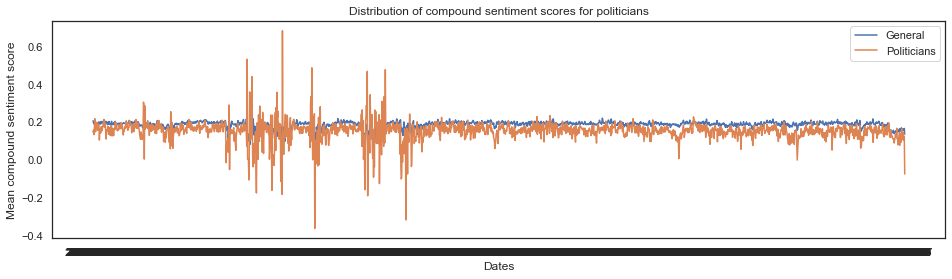

In [32]:
# Visualizing the distribution of compound score for politicans through time
fig, ax = plt.subplots(1,1, figsize = (16,4))
ax.plot(resampled_dfs[0].index, resampled_dfs[0].compound)
ax.plot(resampled_dfs[3].index, resampled_dfs[3].compound)
ax.legend(['General', 'Politicians'])
ax.set_title('Distribution of compound sentiment scores for politicians') 
ax.set_xlabel('Dates')
ax.set_ylabel('Mean compound sentiment score')
ax.set_yscale('linear')
plt.show()

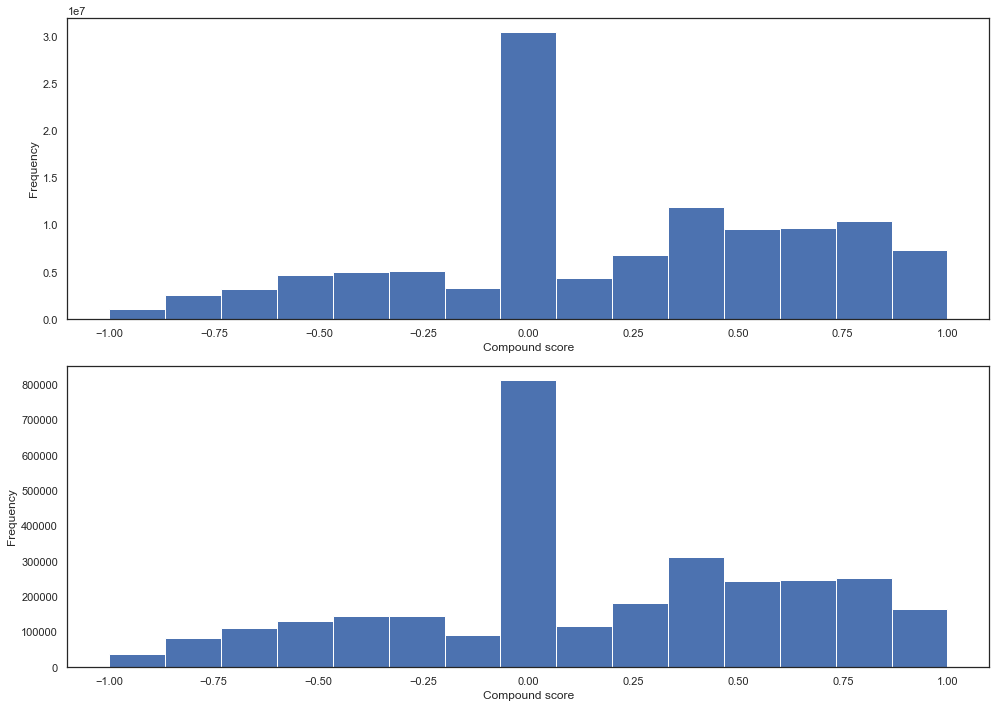

In [20]:
# Plotting the compound score distributions of all data and politicians
fig, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].hist(frames[0].compound, bins=15)
ax[0].set_xlabel('Compound score')
ax[0].set_ylabel('Frequency')
ax[1].hist(frames[3].compound, bins=15)
ax[1].set_xlabel('Compound score')
ax[1].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

Visualizing and exporting distributions in plotly

In [ ]:
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Visualizing subjectivity distribution for politicans and the average quotes
fig = go.Figure(data=[
    go.Bar(name='Politicians', x=politician_df_binned_sub['bins'], y=politician_df_binned_sub['counts'], opacity=0.75),
    go.Bar(name='All', x=df_binned_sub['bins'], y=df_binned_sub['counts'], opacity=0.75)
], layout=layout)

fig.update_layout(title='Subjectivity Distribution', yaxis_title="Normalized and logistic frequency", xaxis_title="Subjectivity scores")

fig.update_layout(barmode='group', template='seaborn')

fig.update_yaxes(type='log')

fig.write_html('plots/bar_dist_sub_pol_all.html', full_html=False, include_plotlyjs='cdn')

fig.show()

In [ ]:
# Visualizing the compound distribution for men and women
fig = go.Figure(data=[
    go.Line(name='Males', x=male_df_binned['bins'], y=male_df_binned['counts']),
    go.Line(name='Females', x=female_df_binned['bins'].tolist(), y=female_df_binned['counts'].tolist())
], layout=layout)

fig.update_layout(title='Compound Distribution', yaxis_title="Normalized and logistic frequency", xaxis_title="Compound score"
)

fig.update_layout(barmode='group', template='seaborn')

fig.update_yaxes(type='log')

fig.write_html('plots/line_dist_comp_males_females.html', full_html=False, include_plotlyjs='cdn')

fig.show()

In [ ]:
# Visualizing the distribution of subjectivity scores for politicans and the entire data set
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df.subjectivity,
    histnorm='percent',
    name='All', 
    xbins=dict(
        start=0.0,
        end=1.0,
        size=0.1
    ),
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=politician_df.subjectivity,
    histnorm='percent',
    name='Politicians',
    xbins=dict(
        start=0.0,
        end=1,
        size=0.1
    ),
    opacity=0.75
))

fig.update_layout(
    title_text='Compound distribution', 
    xaxis_title_text='Value', 
    yaxis_title_text='Frequency', 
    bargap=0.01, 
    bargroupgap=0.01 
)

fig.write_html('plots/line_subjectivity_dist_pol_df.html', full_html=False, include_plotlyjs='cdn')

fig.show()

In [ ]:
# Creating line diagram for average compound score over different time periods for the different demographics
i = 0
timeperiod_names = ['date', 'week', 'month']
frame_names = ['all', 'females', 'males', 'politicians']

for frame in resampled_dfs:
    frame.index = pd.to_datetime(frame.index)

    # Using date, week and month 
    timeperiods = [frame, frame.resample('7D').mean(), frame.resample('M').mean()]
    j = 0
    for timeperiod in timeperiods:
        title = "Mean sentiment of quotes per day for %s" % frame_names[i]
        fig = px.line(timeperiod.compound, title=title, labels={
                    'value': 'Mean sentiment',
                    'variable': 'Type',
                    'Datetime': 'Date'
                    })
        fig.update_layout(showlegend=False)
        fig.data[0].name = 'Sentiment
        fig.write_html('plots/line_compound_%s_%s.html' % (frame_names[i], timeperiod_names[j]), full_html=False,
                        include_plotlyjs='cdn')
        j+=1
        fig.show()
    i+=1

In [ ]:
# Creating line diagram for average compound score over different time periods for the different demographics
pol_week = resampled_dfs[3].resample('7D').mean()
all_week = resampled_dfs[0].resample('7D').mean()

line = px.line(y=[pol_week.compound, all_week.compound], x=pol_week.index, title="Average Compound Score Over Time", category_orders={'Dates': resampled_dfs[3].index}, labels={
                    'value':'Average compound score',
                    'x': 'Time in weeks',
                    'variable': '',
                    }, template='seaborn')

line.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

line.update_traces(hovertemplate='')
line.data[0].name="Politicians"
line.data[1].name="All"

line.write_html('plots/line_compound_pol_all_week.html', full_html=False,
                        include_plotlyjs='cdn')

line.show()

In [ ]:
# Creating line diagram for average compound score over different timeperiods for the different demographics

female_week = resampled_dfs[1].resample('7D').mean()
male_week = resampled_dfs[2].resample('7D').mean()


line_2 = px.line(y=[male_week.compound, female_week.compound], x=male_week.index, title="Average Compound Score Over Time", category_orders={'Dates': resampled_dfs[3].index}, labels={
                    'value':'Average sentiment score',
                    'x': 'Time in weeks',
                    'variable': '',
                    }, template='seaborn')

line_2.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
line_2.update_traces(hovertemplate='')
line_2.data[0].name="Males"
line_2.data[1].name="Females"

line_2.write_html('plots/line_compound_males_females_week.html', full_html=False,
                        include_plotlyjs='cdn')

line_2.show()

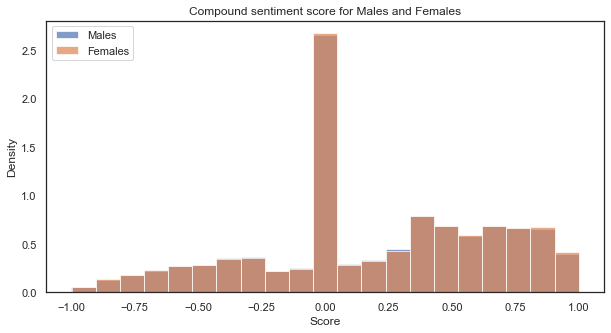

In [185]:
# Plotting the distribution of compound score for men and women on top of eachother
plt.figure(figsize=(10, 5))
plt.hist(male_df['compound'], bins=21,density=True, alpha=0.7, label='Males')
plt.hist(female_df['compound'], bins=21,density=True, alpha=0.7, label='Females')
plt.title("Compound sentiment score for Males and Females")
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### __Mathematical Outline of Methods__
The following cells will deal with the necessary outline of the mathematical concepts that will be used in our analysis
* t-test
* Welch's t-test
* Natural language processing methods

#### Statistical methods

__t-test__

To test whether our results are statistically significant, we will use paired t-tests. The assumption needed to make t-test a valid form for hypothesis test is that the test-statistic is normally distributed. Since we will use the t-test for very large N, and the t-statistic is a sum of independent and identically distributed random variables, this assumption will hold of the central limit theorem.

We will use the t-test to test the differences in mood in different scenarios. For example, to test if the mood in the media on Fridays is more positive than on Mondays. 

The t-statistic:

${t} = \frac{\bar D-\mu _D}{s_D / \sqrt n}$

where $\bar D$ is the sample mean difference between the two distributions. $ \mu _D$ is the real mean difference. $s_D$ is the sample standard deviation of the difference $\bar D$, and $n$ is the number of observations.

As our null hypothesis we will use $H_0: \mu _D = 0$

__Welch's t-test__

We will also use Welch's t-test which is a variant of the t-test for when the two populations we study have unequal variance.

The t-test will for example be used to test the different in sentiment between media outlets as above.

The Welch t-statistic:

${t} = \frac{\bar X_1-\bar X_2}{\sqrt {\frac{s_1^2}{N_1}+\frac{s_2^2}{N_2}}}$

where $\bar X_1- \bar X_2$ is the sample mean difference between the two distributions, $s_i$ is the empirical standard error for $X_i$, and $N_i$ is the number of observations for $X_i$.

Our null hyopthesis for the Welch t-test is also that that the two population means are equal.

#### Natural Language Processing

We will utilize NLTK, a Python library for Natural Language Processing, to complete this project’s natural language processing task. More information about NLTK can be found at _https://www.nltk.org/index.html_, or in the NLT book [1]. Additionally, we use the polarity and subjectivity score of the TextBlob text processing library. More information about TextBlob can be found here: https://textblob.readthedocs.io/.

##### Sentiment Analysis

To study the changes in mood in the media, we will utilize sentiment analysis. Our sentiment analysis will aim to classify whether a quote is positive, neutral, or negative and to which extent it is positive or negative. 

To conduct the sentiment analysis, we will use the [nltk.sentiment.vader](_https://www.nltk.org/api/nltk.sentiment.vader.html_) module. This module uses the Vader rule-based model for sentiment analysis [2]. Vader’s sentiment lexicon consists of over 7500 lexical features, assigned an intensity score between -4 and 4. 

We chose the Vader module because it differentiates between slightly positive words and very positive words. This way, we can capture nuances in the sentiment of quotes.

To quantify the sentiment, we will use the compound score provided by the Vader module. This score is calculated by normalizing the sum of valence scores for the individual words in the quote. The valence scores are calculated by finding the word score in the Vader lexicon. It does also include heuristics, such as giving extra weight to words written in upper case. To summarize, the following formulas calculate the compound score:

$compoundScore = \frac{sum_s}{\sqrt{(sum_s^2+15)}}$ where $sum_s =\sum_{i=1}^{n} valenceScore_i$

To furthermore, enrichen our analysis, we will also use the TextBlob library's polarity and subjectivity scores. By comparing results with NLTK and TextBlob we can study the robustness of our results. The results are stronger if the same conclusion is reached with both sentiment analyzers. The TextBlob sentiment analyzer builds upon the pattern library (https://github.com/clips/pattern). The pattern sentiment uses, like the Vader module, a lexicon to determined the sentiment. More specifically, it used adjectives from product reviews. The polarity sentiment returns a value in the [-1,1] interval where -1 is the most negative. The subjectivity sentiment returns a score on the interval [0,1] with 0 being completley objective and vice versa. More information can be found here: https://github.com/clips/pattern/wiki/pattern-en#sentiment.

### References

1. Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
2. Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.